In [1]:
import urllib.request
import os.path
import gzip
import pickle
import os
import numpy as np
import sys,os

file_path = ['./train-images-idx3-ubyte.gz','./train-labels-idx1-ubyte.gz','./t10k-images-idx3-ubyte.gz','./t10k-labels-idx1-ubyte.gz']

def file_load(path):
  if path.find('images') != -1:
    with gzip.open(path, 'rb') as f:
      data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 784)
    return data
  else:
    with gzip.open(path, 'rb') as f:
      labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

dataset = {}
dataset['train_img'] =  file_load(file_path[0])
dataset['train_label'] = file_load(file_path[1])    
dataset['test_img'] = file_load(file_path[2])
dataset['test_label'] = file_load(file_path[3])


#normalize 
dataset['train_img'] = dataset['train_img'].astype(np.float32)
dataset['train_img'] /= 255.0
dataset['test_img'] = dataset['test_img'].astype(np.float32)
dataset['test_img'] /= 255.0

#one_hot_label
T = np.zeros((dataset['train_label'].size, 10))
for idx, row in enumerate(T):
  row[dataset['train_label'][idx]] = 1
dataset['train_label'] =T
T = np.zeros((dataset['test_label'].size, 10))
for idx, row in enumerate(T):
  row[dataset['test_label'][idx]] = 1
dataset['test_label'] =T

(X_train, Y_train), (X_test, Y_test) = (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 
#(X_train, Y_train), (X_test, Y_test) = load_mnist(normalize=True, one_hot_label=True)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)


In [2]:
import random
def validation_(X_train, n=0.2):
  #X_train = random.shuffle(X_train)
  num = int(X_train.shape[0] * 0.2)
  print(num)
  return X_train[num:], X_train[:num], Y_train[num:], Y_train[:num] #train, vallidation

X_train1, X_train_valid, Y_train1, Y_train_valid = validation_(X_train,n=0.2)
print(X_train1.shape, X_train_valid.shape)
print(Y_train1.shape, Y_train_valid.shape)

12000
(48000, 784) (12000, 784)
(48000, 10) (12000, 10)


In [3]:
class Linear:
  def __init__(self,w,b):
    self.w = w
    self.b = b
    self.dw = 0
    self.db = 0
    self.x = 0

  def forward(self,x):
    #print('Linear_forward')
    self.x = x
    return np.dot(x, self.w)+self.b

  def backward(self,back):
    #print('Linear_backward')
    self.dw = np.dot(self.x.T, back)
    self.db = np.sum(back, axis=0)

    return np.dot(back, self.w.T)

class ReLU:
   def __init__(self):
     self.x_bool = None

   def forward(self,x):
     #print('ReLU_forward')
     self.x_bool = (x<=0) #T/F bool Array
     relu = x.copy()
     relu[self.x_bool] = 0
     return relu

   def backward(self,back):
     #print('ReLU_backward')
     back[self.x_bool] = 0
     return back

class LReLU:
  def __init__(self):
    self.x_bool = None
  
  def forward(self,x):
    self.x_bool = (x<=0)
    lrelu = x.copy()
    lrelu[self.x_bool] *= 0.1
    return lrelu

  def backward(self,back):
    back[self.x_bool] *= 0.1
    return back
    
class Softmax_Cross_Entropy_Error:
  def __init__(self):
    self.loss = 0
    self.p = 0
    self.y = 0

  def forward(self, p, y):
    #print('Softmax_Cross_Entropy_Error_forward')
    self.y = y
    self.p = softmax(p)
    self.loss = cross_entropy_error(self.p, self.y)
    return self.loss

  def backward(self, back = 1):
    #print('Softmax_Cross_Entropy_Error_backward')
    batch_size = self.y.shape[0]
    return (self.p - self.y) / batch_size

In [4]:
from collections import OrderedDict
class ThreeLayerNN_ReLU: #one-hot encoding, normalize, flatten(1,784)
  def __init__(self,input_size, hidden_size, output_size, std = 0.01):
      self.weights = {}
      self.weights['w1'] = std * np.random.randn(input_size,hidden_size)
      self.weights['b1'] = np.zeros(hidden_size)
      self.weights['w2'] = std * np.random.randn(hidden_size,2*hidden_size)
      self.weights['b2'] = np.zeros(2*hidden_size)
      self.weights['w3'] = std * np.random.randn(2*hidden_size, output_size)
      self.weights['b3'] = np.zeros(output_size)

      self.layers = {}
      self.layers['L1'] = Linear(self.weights['w1'], self.weights['b1'])
      self.layers['A1'] = ReLU()
      self.layers['L2'] = Linear(self.weights['w2'], self.weights['b2'])
      self.layers['A2'] = ReLU()
      self.layers['L3'] = Linear(self.weights['w3'], self.weights['b3'])
      
      self.layers['softmax_cross'] = Softmax_Cross_Entropy_Error()

  def forward(self,x):
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    return layer3
  
  def loss(self,x, y):
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    loss = self.layers['softmax_cross'].forward(layer3, y)
    return loss
  
  def accuracy(self,x, y):
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    p = np.argmax(layer3, axis = 1) #argmax는 가장 큰 값의 인덱스 값을 반환한다.
    #one_hot encoding이니까 if문 적용 x.!!
    y = np.argmax(y, axis=1) #행 (1,batch_size)
    accuracy = np.sum(y == p) / float(x.shape[0]) #batch_size로 나눠
    return accuracy
  
  def back_propagate_train(self, x, y):
    #forward
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    loss = self.layers['softmax_cross'].forward(layer3, y)
    #backward
    back_layer3 = self.layers['L3'].backward(self.layers['softmax_cross'].backward())
    back_layer2_Relu = self.layers['A2'].backward(back_layer3)
    back_layer2 = self.layers['L2'].backward(back_layer2_Relu)
    back_layer1_Relu = self.layers['A1'].backward(back_layer2)
    back_layer1 = self.layers['L1'].backward(back_layer1_Relu)

    gradients = {}
    gradients['w1'] = self.layers['L1'].dw
    gradients['b1'] = self.layers['L1'].db
    gradients['w2'] = self.layers['L2'].dw
    gradients['b2'] = self.layers['L2'].db
    gradients['w3'] = self.layers['L3'].dw
    gradients['b3'] = self.layers['L3'].db

    return gradients

In [5]:
from collections import OrderedDict
class ThreeLayerNN_LReLU: #one-hot encoding, normalize, flatten(1,784)
  def __init__(self,input_size, hidden_size, output_size, std = 0.01):
      self.weights = {}
      self.weights['w1'] = std * np.random.randn(input_size,hidden_size)
      self.weights['b1'] = np.zeros(hidden_size)
      self.weights['w2'] = std * np.random.randn(hidden_size,2*hidden_size)
      self.weights['b2'] = np.zeros(2*hidden_size)
      self.weights['w3'] = std * np.random.randn(2*hidden_size, output_size)
      self.weights['b3'] = np.zeros(output_size)

      self.layers = {}
      self.layers['L1'] = Linear(self.weights['w1'], self.weights['b1'])
      self.layers['A1'] = LReLU()
      self.layers['L2'] = Linear(self.weights['w2'], self.weights['b2'])
      self.layers['A2'] = LReLU()
      self.layers['L3'] = Linear(self.weights['w3'], self.weights['b3'])
      
      self.layers['softmax_cross'] = Softmax_Cross_Entropy_Error()

  def forward(self,x):
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    return layer3
  
  def loss(self,x, y):
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    loss = self.layers['softmax_cross'].forward(layer3, y)
    return loss
  
  def accuracy(self,x, y):
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    p = np.argmax(layer3, axis = 1) #argmax는 가장 큰 값의 인덱스 값을 반환한다.
    #one_hot encoding이니까 if문 적용 x.!!
    y = np.argmax(y, axis=1) #행 (1,batch_size)
    accuracy = np.sum(y == p) / float(x.shape[0]) #batch_size로 나눠
    return accuracy
  
  def back_propagate_train(self, x, y):
    #forward
    layer1 = self.layers['L1'].forward(x)
    layer1_Relu = self.layers['A1'].forward(layer1)
    layer2 = self.layers['L2'].forward(layer1_Relu)
    layer2_Relu = self.layers['A2'].forward(layer2)
    layer3 = self.layers['L3'].forward(layer2_Relu)

    loss = self.layers['softmax_cross'].forward(layer3, y)
    #backward
    back_layer3 = self.layers['L3'].backward(self.layers['softmax_cross'].backward())
    back_layer2_Relu = self.layers['A2'].backward(back_layer3)
    back_layer2 = self.layers['L2'].backward(back_layer2_Relu)
    back_layer1_Relu = self.layers['A1'].backward(back_layer2)
    back_layer1 = self.layers['L1'].backward(back_layer1_Relu)

    gradients = {}
    gradients['w1'] = self.layers['L1'].dw
    gradients['b1'] = self.layers['L1'].db
    gradients['w2'] = self.layers['L2'].dw
    gradients['b2'] = self.layers['L2'].db
    gradients['w3'] = self.layers['L3'].dw
    gradients['b3'] = self.layers['L3'].db

    return gradients

In [6]:
#각종 함수들
def softmax(x):
    #if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T
def cross_entropy_error(p,y):
  #if p.ndim == 1:
    #y = y.reshape(1, y.size)
    #p = p.reshape(1, p.size)#

  batch_size = p.shape[0]
  return -np.sum(y*np.log(p+1e-7)) / batch_size

In [7]:
%%time
#train, test
batch_size = 100
lr = 0.1

train_loss =[]
valid_loss= []
train_acc = []
valid_acc = []
x_plot = []
n = 0

epoch = X_train1.shape[0] / batch_size #epoch 48000/100 = 480
model = ThreeLayerNN_ReLU(input_size=784, hidden_size = 50, output_size = 10)

for i in range(10000):
  batch = np.random.choice(X_train1.shape[0], batch_size)
  X_train_b = X_train1[batch]
  Y_train_b = Y_train1[batch]
  #back_propagate
  gradients = model.back_propagate_train(X_train_b, Y_train_b) #안에 forward과정 있음
  model.weights['w1'] -= lr * gradients['w1']
  model.weights['b1'] -= lr * gradients['b1']
  model.weights['w2'] -= lr * gradients['w2']
  model.weights['b2'] -= lr * gradients['b2']
  model.weights['w3'] -= lr * gradients['w3']
  model.weights['b3'] -= lr * gradients['b3']
  
  #update 후
  #loss = model.loss(X_train_b, Y_train_b)
  #train_loss.append(loss)
  if i % epoch == 0:
    x_plot.append(n) #count epoch
    n+=1
    train_l = model.loss(X_train1,Y_train1) #전체 trainset loss계산
    valid_l = model.loss(X_train_valid, Y_train_valid)
    train_loss.append(train_l)
    valid_loss.append(valid_l)
    print("train loss: ",train_l,"valid loss: ", valid_l)
    train_a = model.accuracy(X_train1,Y_train1)
    valid_a = model.accuracy(X_train_valid, Y_train_valid)
    train_acc.append(train_a)
    valid_acc.append(valid_a)
    print("train accuracy: ",train_a,"valid accuracy: ", valid_a)

train loss:  2.3025798662675294 valid loss:  2.302602643014337
train accuracy:  0.09841666666666667 valid accuracy:  0.09391666666666666
train loss:  1.3140366707307645 valid loss:  1.3043020259807292
train accuracy:  0.5684791666666666 valid accuracy:  0.563
train loss:  0.4323143885428391 valid loss:  0.4309857279885257
train accuracy:  0.8704375 valid accuracy:  0.8741666666666666
train loss:  0.3469495347084901 valid loss:  0.34500439026102
train accuracy:  0.891625 valid accuracy:  0.895
train loss:  0.23791759192436887 valid loss:  0.24163242376225955
train accuracy:  0.930625 valid accuracy:  0.93075
train loss:  0.19333148325003652 valid loss:  0.208805561260843
train accuracy:  0.9436458333333333 valid accuracy:  0.9380833333333334
train loss:  0.1642136636079741 valid loss:  0.17877425391342824
train accuracy:  0.9516458333333333 valid accuracy:  0.9469166666666666
train loss:  0.13672943209496397 valid loss:  0.1553942819651151
train accuracy:  0.9599166666666666 valid accur

In [8]:
#ReLU test accuracy
test_a = model.accuracy(X_test,Y_test)
print(test_a)

0.9701


[[ 972    0    0    0    0    0    1    1    4    2]
 [   0 1122    3    3    0    1    1    1    4    0]
 [   9    3  990    7    4    1    3    9    6    0]
 [   0    0    6  985    1    6    0    6    3    3]
 [   0    0    5    0  959    0    3    1    0   14]
 [   5    1    0   13    2  853    5    0    7    6]
 [  14    3    2    1    9    3  922    0    4    0]
 [   2    8   10    4    3    0    0  993    0    8]
 [  11    1    3    5    5    5    2    5  933    4]
 [   2    5    0    4   11    6    0    6    3  972]]


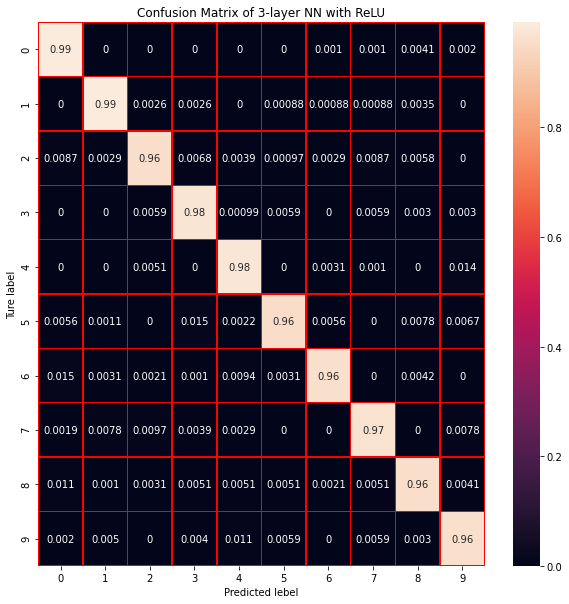

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(Y_test, axis = 1), np.argmax(model.forward(X_test), axis =1))
print(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm_normalized,annot=True,linewidths=0.5,linecolor="red",ax=ax)
plt.xlabel("Predicted lebel")
plt.ylabel("Ture label")
plt.title('Confusion Matrix of 3-layer NN with ReLU')
plt.show()

10 [[0.9999999998248235, 0.9999999998013787, 0.9999999996765021], [0.9999967472509814, 0.9999973015000589, 0.9999966658172069], [0.9999999996417768, 0.9999999988693928, 0.9999999998465161], [0.9999999999958731, 0.9999999999742419, 0.9999999999719138], [0.9999998984866029, 0.9999999173284317, 0.9999998838291475], [0.9999999999994951, 0.9999999999993598, 0.9999999999993647], [0.9999999839322633, 0.9999999640230341, 0.9999999639876116], [0.9999999673224913, 0.9999999546722774, 0.9999998983332733], [0.9999999750863253, 0.9999999869449261, 0.9999999890928527], [0.9999994186558163, 0.9999987999954623, 0.9999987059597831]]
10 [[5669, 6127, 6129], [2626, 5859, 8568], [6412, 8460, 1053], [8777, 4162, 9460], [27, 56, 8790], [9109, 9160, 7965], [7787, 7753, 7792], [6119, 8475, 8480], [8015, 5846, 3882], [8053, 4553, 8935]]
10 [[5669, 6127, 6129], [5859, 2626, 8568], [1053, 6412, 8460], [8777, 4162, 9460], [56, 27, 8790], [9109, 7965, 9160], [7787, 7753, 7792], [6119, 8475, 8480], [3882, 5846, 801

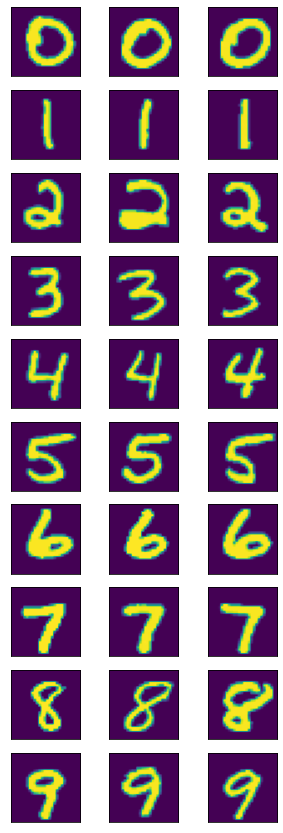

In [10]:
Y_index = [ [] for i in range(Y_test.shape[1]) ] #class수 만큼 생성
pred_index = [ [0]*3 for i in range(Y_test.shape[1])]

hist = [ [0]*3 for i in range(Y_test.shape[1])]

def class_prior(X_test,Y_test):
  Y = np.argmax(Y_test, axis = 1)
  for i in range(Y_test.shape[0]):
    Y_index[Y[i]].append(i) #해당 class에 index 넣기
  for j in range(len(Y_index)):
    for i in Y_index[j]:
      pred_y = np.max(softmax(model.forward(X_test[i])))
      if min(pred_index[j]) < pred_y:
        pred_index[j][pred_index[j].index(min(pred_index[j]))] = pred_y
        hist[j][pred_index[j].index(min(pred_index[j]))] = i
  print(len(pred_index),pred_index)
  print(len(hist), hist)

  new_hist = [ [0]*3 for i in range(Y_test.shape[1]) ] 
  #역정렬
  for cl in range(len(pred_index)):
    new = sorted(pred_index[cl],reverse=True)
    for i in range(len(pred_index[cl])): #i가 원래 index
      new_index = new.index(pred_index[cl][i])
      new_hist[cl][new_index] = hist[cl][i]
  print(len(new_hist), new_hist)
        
  fig = plt.figure()#plt.subplots(figsize=(10,10))
  n = 1
  for i in new_hist:
    for j in range(len(i)):
      subplot = fig.add_subplot(10,3,n)
      n+=1
      image = X_test[i[j]].reshape((28,28))
      fig.set_figheight(15)
      fig.set_figwidth(5)
      subplot.imshow(image)
      # x, y 축의 지점 표시를 안함
      subplot.set_xticks([])
      subplot.set_yticks([])
  plt.show()

class_prior(X_test,Y_test)

In [11]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt

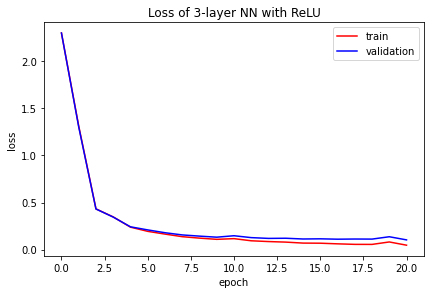

In [12]:
#plot
def plot_(train_loss, valid_loss): #train set, validation set
  plt.title('Loss of 3-layer NN with ReLU')
  plt.tight_layout()
  plt.plot(x_plot,train_loss,color="red",label = 'train')
  plt.plot(x_plot,valid_loss,color="blue", label = 'validation')
  plt.ylabel('loss')
  plt.xlabel('epoch') #y_label 1이 최대로 줄이기
  plt.legend()

plot_(train_loss, valid_loss)

In [13]:
%%time
#train, test
batch_size = 100
lr = 0.1

train_loss =[]
valid_loss= []
train_acc = []
valid_acc = []
x_plot = []
n = 0

epoch = X_train1.shape[0] / batch_size #epoch 48000/100 = 480
model = ThreeLayerNN_LReLU(input_size=784, hidden_size = 50, output_size = 10)

for i in range(10000):
  batch = np.random.choice(X_train1.shape[0], batch_size)
  X_train_b = X_train1[batch]
  Y_train_b = Y_train1[batch]
  #back_propagate
  gradients = model.back_propagate_train(X_train_b, Y_train_b)
  model.weights['w1'] -= lr * gradients['w1']
  model.weights['b1'] -= lr * gradients['b1']
  model.weights['w2'] -= lr * gradients['w2']
  model.weights['b2'] -= lr * gradients['b2']
  model.weights['w3'] -= lr * gradients['w3']
  model.weights['b3'] -= lr * gradients['b3']
  
  #update 후
  #loss = model.loss(X_train_b, Y_train_b)
  #train_loss.append(loss)
  if i % epoch == 0:
    x_plot.append(n) #count epoch
    n+=1
    train_l = model.loss(X_train1,Y_train1) #전체 trainset loss계산
    valid_l = model.loss(X_train_valid, Y_train_valid)
    train_loss.append(train_l)
    valid_loss.append(valid_l)
    print("train loss: ",train_l,"valid loss: ", valid_l)
    train_a = model.accuracy(X_train1,Y_train1)
    valid_a = model.accuracy(X_train_valid, Y_train_valid)
    train_acc.append(train_a)
    valid_acc.append(valid_a)
    print("train accuracy: ",train_a,"valid accuracy: ", valid_a)

train loss:  2.30250642906009 valid loss:  2.3025132867304223
train accuracy:  0.1123125 valid accuracy:  0.11258333333333333
train loss:  0.8962615297604923 valid loss:  0.891860445651938
train accuracy:  0.6843958333333333 valid accuracy:  0.6805833333333333
train loss:  0.421147144646023 valid loss:  0.41876835844824245
train accuracy:  0.8762708333333333 valid accuracy:  0.8818333333333334
train loss:  0.3016272577238705 valid loss:  0.30198726368793366
train accuracy:  0.9109583333333333 valid accuracy:  0.9155833333333333
train loss:  0.2358960010916959 valid loss:  0.23545412260813206
train accuracy:  0.9325625 valid accuracy:  0.9335
train loss:  0.2013548958499315 valid loss:  0.2095599021244442
train accuracy:  0.9400208333333333 valid accuracy:  0.9374166666666667
train loss:  0.16277166353870534 valid loss:  0.17235949822942392
train accuracy:  0.9539375 valid accuracy:  0.9490833333333333
train loss:  0.15312890766068943 valid loss:  0.1633938391813813
train accuracy:  0.9

In [14]:
#LReLU test accuracy
test_a = model.accuracy(X_test,Y_test)
print(test_a)

0.9682


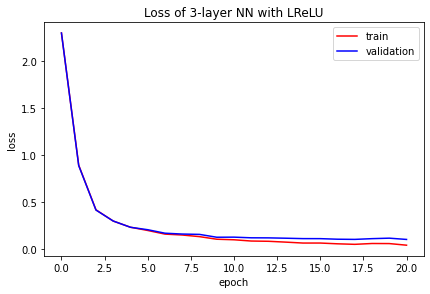

In [15]:
#plot
def plot_(train_loss, valid_loss): #train set, validation set
  plt.title('Loss of 3-layer NN with LReLU')
  plt.tight_layout()
  plt.plot(x_plot,train_loss,color="red",label = 'train')
  plt.plot(x_plot,valid_loss,color="blue", label = 'validation')
  plt.ylabel('loss')
  plt.xlabel('epoch') #y_label 1이 최대로 줄이기
  plt.legend()

plot_(train_loss, valid_loss)

[[ 964    0    1    1    1    1    4    1    5    2]
 [   0 1123    1    2    0    1    3    0    5    0]
 [   6    3  998    2    3    0    6    4   10    0]
 [   0    2    5  984    1    2    0    4   11    1]
 [   1    0    0    0  958    0    8    1    6    8]
 [   5    1    0   14    1  838   10    0   19    4]
 [   3    3    1    0    6    3  939    0    3    0]
 [   1   11   14    7    4    0    0  976    3   12]
 [   2    3    1    3    4    3    4    1  952    1]
 [   1    7    0    7   15    3    2    5   19  950]]


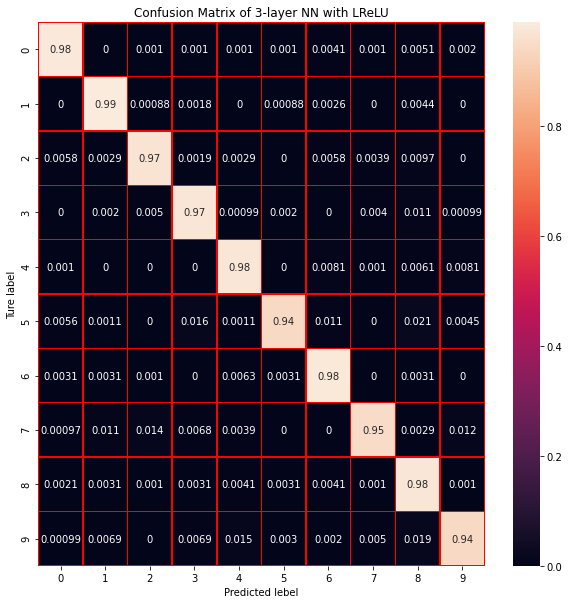

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(Y_test, axis = 1), np.argmax(model.forward(X_test), axis =1))
print(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm_normalized,annot=True,linewidths=0.5,linecolor="red",ax=ax)
plt.xlabel("Predicted lebel")
plt.ylabel("Ture label")
plt.title('Confusion Matrix of 3-layer NN with LReLU')
plt.show()

10 [[0.999999996561914, 0.9999999998620595, 0.9999999950685647], [0.9999986129988705, 0.9999994714972162, 0.9999987119442599], [0.9999999999996334, 0.9999999999253284, 0.9999999999882201], [0.9999999995509348, 0.9999999996238766, 0.9999999991110864], [0.9999999999461362, 0.9999999997620896, 0.99999999987632], [0.9999999904676723, 0.9999999936462385, 0.9999999994602797], [0.9999999999661278, 0.999999999978352, 0.9999999999363638], [0.9999996632837046, 0.9999999773725111, 0.9999996759940788], [0.999999999992554, 0.9999999995688256, 0.9999999997680131], [0.9999978939429418, 0.9999963953813286, 0.9999965729010052]]
10 [[6129, 5368, 8458], [3741, 3651, 3455], [1407, 7022, 4517], [648, 4406, 6382], [8757, 8775, 2340], [9109, 155, 6908], [6128, 7792, 8013], [9393, 9077, 8926], [7901, 8015, 6161], [8784, 9404, 4553]]
[0.9999999998620595, 0.999999996561914, 0.9999999950685647]
[0.9999994714972162, 0.9999987119442599, 0.9999986129988705]
[0.9999999999996334, 0.9999999999882201, 0.999999999925328

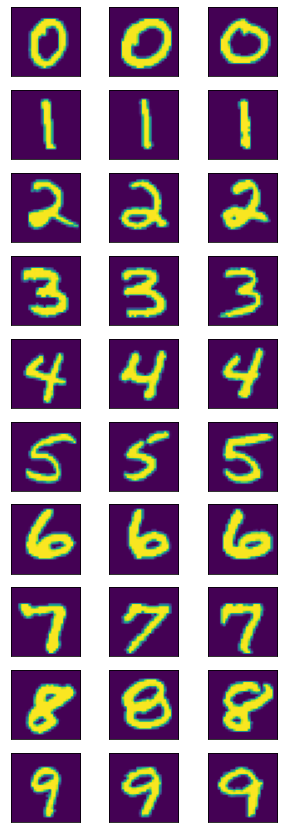

In [17]:
Y_index = [ [] for i in range(Y_test.shape[1]) ] #class수 만큼 생성
pred_index = [ [0]*3 for i in range(Y_test.shape[1])]

hist = [ [0]*3 for i in range(Y_test.shape[1])]

def class_prior(X_test,Y_test):
  Y = np.argmax(Y_test, axis = 1)
  for i in range(Y_test.shape[0]):
    Y_index[Y[i]].append(i) #해당 class에 index 넣기
  for j in range(len(Y_index)):
    for i in Y_index[j]:
      pred_y = np.max(softmax(model.forward(X_test[i])))
      if min(pred_index[j]) < pred_y:
        pred_index[j][pred_index[j].index(min(pred_index[j]))] = pred_y
        hist[j][pred_index[j].index(min(pred_index[j]))] = i
  print(len(pred_index),pred_index)
  print(len(hist), hist)

  new_hist = [ [0]*3 for i in range(Y_test.shape[1]) ] 
  #역정렬
  for cl in range(len(pred_index)):
    new = sorted(pred_index[cl],reverse=True)
    for i in range(len(pred_index[cl])): #i가 원래 index
      new_index = new.index(pred_index[cl][i])
      new_hist[cl][new_index] = hist[cl][i]
    print(new)
  print(len(new_hist), new_hist)
        
  fig = plt.figure()#plt.subplots(figsize=(10,10))
  n = 1
  for i in new_hist:
    for j in range(len(i)):
      subplot = fig.add_subplot(10,3,n)
      n+=1
      image = X_test[i[j]].reshape((28,28))
      fig.set_figheight(15)
      fig.set_figwidth(5)
      subplot.imshow(image)
      # x, y 축의 지점 표시를 안함
      subplot.set_xticks([])
      subplot.set_yticks([])
  plt.show()

class_prior(X_test,Y_test)